# <center>Machine Learning Group Project - Movie Lens (Group 11)</center>
<center>Nova SBE, Spring 2021</center>
<center>Professor Qiwei Han</center>
<center>Teaching Assistant José Lucas</center>
.
<center>Authors:</center>
<center>Ângelo Figueiral, 44645</center>
<center>Diogo Cardoso, 45124</center>
<center>Pedro Rolim, 29067</center>
<center>Ricardo Araújo, 32025</center>

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Table of Contents
1. [Sources](#Sources) (MISSING)
1. [Data Curation](#Data-Curation)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis) (MISSING)
3. [Business Problem](#Business-Problem)
4. [First Approach - Without Machine Learning](#First-Approach---Without-Machine-Learning)
5. [Second Approach - Neural Network](#Second-Approach---Neural-Network) (MISSING)
6. [Best Model](#Best-Model) (MISSING)
7. [Business Applications](#Business-Applications) (MISSING)
8. [Limitations](#Limitations) (MISSING) (VER SE SE APLICA)

# Sources

# Data Curation

The dataset given to us was MovieLens. We got basic data from Movies, from the ratings of these movies and respective users, the genres of the films and tags.

In [2]:
movies_df = pd.read_csv('../../dataset/MovieLens_files/movies.csv')
ratings_df = pd.read_csv('../../dataset/MovieLens_files/ratings.csv')
# tags_df = pd.read_csv('../../dataset/MovieLens_files/tags.csv')

In [3]:
films_df = movies_df['title'].str.extract('(.*)\((\d{4})\)', expand=False)

films_df["movieId"] = movies_df['movieId']
films_df["genres"] = movies_df['genres']
films_df.columns = ['title', 'year', 'movieId', 'genres']
films_df = films_df[['movieId', 'title', 'year', 'genres']]
films_df.head()

movieId                         title  year  \
0        1                    Toy Story   1995   
1        2                      Jumanji   1995   
2        3             Grumpier Old Men   1995   
3        4            Waiting to Exhale   1995   
4        5  Father of the Bride Part II   1995   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

# Exploratory Data Analysis

The group first tried to get acquainted to the data and tried to see any patterns or important information.

In [4]:
films_df.describe()

movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000

### Checking the evolution of number of movies and genres per year, across all the dataset

In [5]:
films_genres_df.groupby('year').sum().iloc[-100:,1:].plot.bar(stacked=True,figsize=(25, 10), title='Number of Movies by Genre per Year')

NameError: name 'films_genres_df' is not defined

In [ ]:
# MISSING: FAZER MAIS CENAS RELACIONADAS COM RATINGS

In [18]:
ratings_df.head(5)

userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580

Before starting to think about which problem to solve or a model to implement, it is important that we have some information on a key variable in our dataset: the ratings users have given to movies.

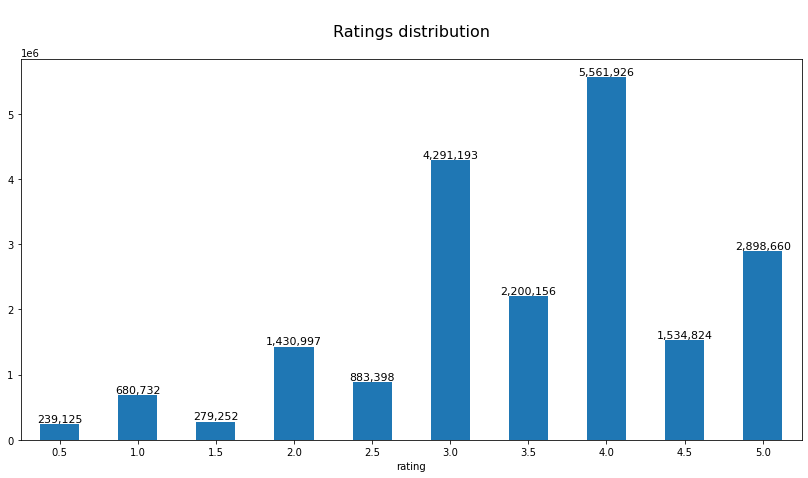

In [66]:
ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')].plot.bar(figsize = (14,7), rot = 0)
   
plt.title('\nRatings distribution\n', {"fontsize": 16})
for i in range(0,10):
    plt.text(i, (ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')][np.sort(ratings_df['rating'].unique())[i]]), 
             f"{int(ratings_df.groupby('rating').agg(['count'])[(   'userId', 'count')][np.sort(ratings_df['rating'].unique())[i]]):,}", 
             horizontalalignment='center',
             fontsize = 11,
             verticalalignment='bottom')
plt.yticks([])
plt.show()

- As we can see in the bar chart above, it is unusual for users to give ratings lower than 2.
- The most given rating was 4, while the second and third most given were 3 and 5, respectively.

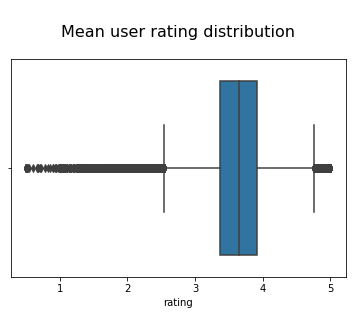

In [72]:
import seaborn as sns
ax = sns.boxplot(x=(ratings_df.groupby('userId').mean()['rating']))
plt.title('\nMean user rating distribution\n', {"fontsize": 16})
plt.show()

By plotting the average movie rating of each user using a boxplot, we see that most of the data points are concentrated between approximately 3.25 and 4, with the averages below 2.5 and 4.8 being considered outliers. With this information, we can conclude that the majority of users is pondered in the ratings they give to movies, once they tend not to give ratings neither too high nor too low.

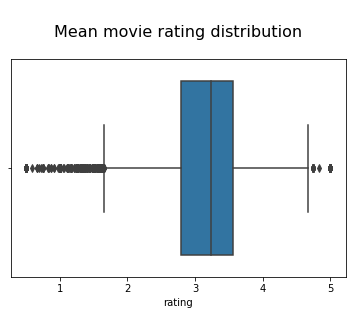

In [71]:
import seaborn as sns
ax = sns.boxplot(x=ratings_df.groupby('movieId').mean()['rating'])
plt.title('\nMean movie rating distribution\n', {"fontsize": 16})
plt.show()

Finally it is also important to see what did users, on average, think of each movie. Again, we see that the majority of movies have an average rating between 2.8 and 3.6, being uncommon to find movies with higer or lower ratings than that.

# Business Problem

Through this notebook, we try to provide a possible solution to a big problem that streaming services have at the moment: currently, Netlfix has over 13,612 titles in its library, Disney+ has more than 7,500 television episodes and 500 film titles, and HBO MAX has more 2000 titles. It would be a waste of a client's time to have to scroll through 13000 random titles to get to a film the user wants to watch.

Indeed, these platforms already use very complex recommendation systems, which result in the maximization of the users' time watching and satisfaction with the service, ultimately leading to much higher profits. Nowadays, a streaming service without an avanced recommendation systems is considered obsolete. Reportedly, 80% of Netflix's stream time is achieved through their very complex ensemble of models (https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48).

While we will not be using and testing several different models, we aim at implementing a model that receives a user ID and returns a list of movies that are recommended to him, based on his past ratings.

### Do we even need Machine Learning for this problem?

This is an important question. If we can solve this problem without Machine Learning, it would be beneficial for the company because it means less resources needed. Below, we implement a simple recommendation system without Machine Learning, in order to find out whether a better solution is needed.

# First Approach - Without Machine Learning

In [9]:
new_movies_df = pd.merge(ratings_df, movies_df[['movieId', 'title']],on="movieId")
new_movies_df.head()

userId  movieId  rating   timestamp           title
0       1        2     3.5  1112486027  Jumanji (1995)
1       5        2     3.0   851527569  Jumanji (1995)
2      13        2     3.0   849082742  Jumanji (1995)
3      29        2     3.0   835562174  Jumanji (1995)
4      34        2     3.0   846509384  Jumanji (1995)

In [10]:
# Seeing what are the best rated films in the dataset
new_movies_df.groupby("title").mean()['rating'].sort_values(ascending=False).head(10)

title
Prom Queen: The Marc Hall Story (2004)                        5.0
The Garden of Sinners - Chapter 5: Paradox Paradigm (2008)    5.0
Death of a Nation - The Timor Conspiracy (1994)               5.0
Poison (1951)                                                 5.0
Sun Kissed (2012)                                             5.0
Giorgino (1994)                                               5.0
Schmatta: Rags to Riches to Rags (2009)                       5.0
De la servitude moderne (2009)                                5.0
The Encounter (2010)                                          5.0
Best of Ernie and Bert, The (1988)                            5.0
Name: rating, dtype: float64

In [11]:
# Creating a new dataframe with the movie title, avg_rating and the number of times the movie was rated.
new_ratings_df1 = new_movies_df.groupby(new_movies_df['title']).mean().reset_index()[['title', 'rating']]
new_ratings_df2 = new_movies_df.groupby(new_movies_df['title']).count().reset_index()[['title', 'rating']]

new_ratings_df = new_ratings_df1.merge(new_ratings_df2, on="title")
new_ratings_df.columns = ['title', 'avg_rating', 'count_rating']
new_ratings_df.sort_values(by='avg_rating', ascending=False)

title  avg_rating  \
18750             Prom Queen: The Marc Hall Story (2004)         5.0   
23270  The Garden of Sinners - Chapter 5: Paradox Par...         5.0   
6223     Death of a Nation - The Timor Conspiracy (1994)         5.0   
18369                                      Poison (1951)         5.0   
22392                                  Sun Kissed (2012)         5.0   
...                                                  ...         ...   
23520               The Robot vs. the Aztec Mummy (1958)         0.5   
15295                                Mega Piranha (2010)         0.5   
23504                           The Radio Pirates (2007)         0.5   
8400                             First Texan, The (1956)         0.5   
996     Allan Quatermain and the Temple of Skulls (2008)         0.5   

       count_rating  
18750             1  
23270             1  
6223              1  
18369             1  
22392             1  
...             ...  
23520             1  
15295             1  
23504             1  
8400              1  
996               1  

[26729 rows x 3 columns]

### Seeing the best rated movies in the dataset, most of them are movies that are not known and have been rated only one time.

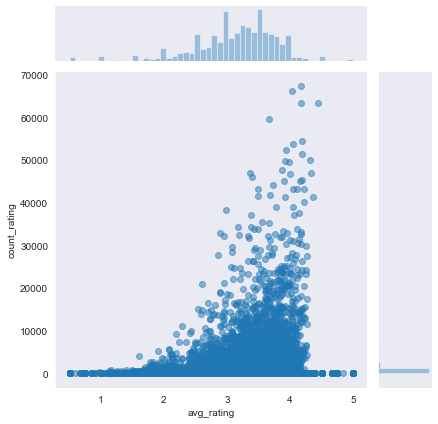

In [12]:
# Seeing the relationship between average rating and the number of times the film is rated.
sns.jointplot(x='avg_rating',y='count_rating',data=new_ratings_df,alpha=0.5)

# Insights from plot

- We can see in the plot that most films have less than 10000 ratings and there are a very small number of films that are highly popular (rated a lot of times) and highly rated (more than 3.5 stars).

**We have to find a way to take out the movies that are seen only a few number of times for the model to work.**

In [13]:
new_ratings_df['count_rating'].describe()

count    26729.000000
mean       748.260803
std       3086.673456
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
Name: count_rating, dtype: float64

#### The group assumed 800 was a reasonable number of reviews for a film to be accepted in our recommendation system. This was a crucial step because it was important for our recommendation system to be unbiased and to work to the best it could.

In [14]:
new_ratings_df = new_ratings_df[new_ratings_df['count_rating']>800]

# Filtering in our original dataset by the films that have more than 800 ratings
new_movies_df = new_movies_df.groupby("title").filter(lambda x: len(x) >= 800)

In [15]:
moviematrix = new_movies_df.pivot_table(index="userId",columns="title",values='rating')
moviematrix.tail()

title   'burbs, The (1989)  (500) Days of Summer (2009)  \
userId                                                    
138489                 NaN                          NaN   
138490                 NaN                          NaN   
138491                 NaN                          NaN   
138492                 NaN                          NaN   
138493                 NaN                          NaN   

title   *batteries not included (1987)  ...And Justice for All (1979)  \
userId                                                                  
138489                             NaN                            NaN   
138490                             NaN                            NaN   
138491                             NaN                            NaN   
138492                             NaN                            NaN   
138493                             NaN                            NaN   

title   10 Things I Hate About You (1999)  10,000 BC (2008)  \
userId                                                        
138489                                NaN               NaN   
138490                                NaN               NaN   
138491                                NaN               NaN   
138492                                NaN               NaN   
138493                                NaN               NaN   

title   101 Dalmatians (1996)  \
userId                          
138489                    NaN   
138490                    NaN   
138491                    NaN   
138492                    NaN   
138493                    3.0   

title   101 Dalmatians (One Hundred and One Dalmatians) (1961)  \
userId                                                           
138489                                                NaN        
138490                                                NaN        
138491                                                2.5        
138492                                                NaN        
138493                                                3.5        

title   102 Dalmatians (2000)  12 Angry Men (1957)  ...  \
userId                                              ...   
138489                    NaN                  4.5  ...   
138490                    NaN                  NaN  ...   
138491                    NaN                  NaN  ...   
138492                    NaN                  NaN  ...   
138493                    NaN                  4.0  ...   

title   Zero Dark Thirty (2012)  Zero Effect (1998)  Zodiac (2007)  \
userId                                                               
138489                      NaN                 NaN            NaN   
138490                      NaN                 NaN            NaN   
138491                      NaN                 NaN            NaN   
138492                      NaN                 NaN            NaN   
138493                      NaN                 NaN            NaN   

title   Zombieland (2009)  Zoolander (2001)  Zulu (1964)  [REC] (2007)  \
userId                                                                   
138489                NaN               NaN          NaN           NaN   
138490                NaN               NaN          NaN           NaN   
138491                NaN               NaN          NaN           NaN   
138492                NaN               NaN          NaN           NaN   
138493                NaN               NaN          NaN           NaN   

title   eXistenZ (1999)  xXx (2002)  ¡Three Amigos! (1986)  
userId                                                      
138489              NaN         NaN                    NaN  
138490              NaN         NaN                    NaN  
138491              NaN         NaN                    NaN  
138492              NaN         NaN                    NaN  
138493              NaN         NaN                    NaN  

[5 rows x 3556 columns]

In [26]:
moviematrix.tail(5)

title   'burbs, The (1989)  (500) Days of Summer (2009)  \
userId                                                    
138489                 NaN                          NaN   
138490                 NaN                          NaN   
138491                 NaN                          NaN   
138492                 NaN                          NaN   
138493                 NaN                          NaN   

title   *batteries not included (1987)  ...And Justice for All (1979)  \
userId                                                                  
138489                             NaN                            NaN   
138490                             NaN                            NaN   
138491                             NaN                            NaN   
138492                             NaN                            NaN   
138493                             NaN                            NaN   

title   10 Things I Hate About You (1999)  10,000 BC (2008)  \
userId                                                        
138489                                NaN               NaN   
138490                                NaN               NaN   
138491                                NaN               NaN   
138492                                NaN               NaN   
138493                                NaN               NaN   

title   101 Dalmatians (1996)  \
userId                          
138489                    NaN   
138490                    NaN   
138491                    NaN   
138492                    NaN   
138493                    3.0   

title   101 Dalmatians (One Hundred and One Dalmatians) (1961)  \
userId                                                           
138489                                                NaN        
138490                                                NaN        
138491                                                2.5        
138492                                                NaN        
138493                                                3.5        

title   102 Dalmatians (2000)  12 Angry Men (1957)  ...  \
userId                                              ...   
138489                    NaN                  4.5  ...   
138490                    NaN                  NaN  ...   
138491                    NaN                  NaN  ...   
138492                    NaN                  NaN  ...   
138493                    NaN                  4.0  ...   

title   Zero Dark Thirty (2012)  Zero Effect (1998)  Zodiac (2007)  \
userId                                                               
138489                      NaN                 NaN            NaN   
138490                      NaN                 NaN            NaN   
138491                      NaN                 NaN            NaN   
138492                      NaN                 NaN            NaN   
138493                      NaN                 NaN            NaN   

title   Zombieland (2009)  Zoolander (2001)  Zulu (1964)  [REC] (2007)  \
userId                                                                   
138489                NaN               NaN          NaN           NaN   
138490                NaN               NaN          NaN           NaN   
138491                NaN               NaN          NaN           NaN   
138492                NaN               NaN          NaN           NaN   
138493                NaN               NaN          NaN           NaN   

title   eXistenZ (1999)  xXx (2002)  ¡Three Amigos! (1986)  
userId                                                      
138489              NaN         NaN                    NaN  
138490              NaN         NaN                    NaN  
138491              NaN         NaN                    NaN  
138492              NaN         NaN                    NaN  
138493              NaN         NaN                    NaN  

[5 rows x 3556 columns]

In [69]:
# Function to recommend a user some movies based on their preferences

def predict_movies(user_id):
    
    # Get the user's favorite movie
    fav_movie = moviematrix.loc[user_id].idxmax(axis=1)
    
    # Get ratings of the user's favorite movie
    movie_user_ratings=moviematrix[fav_movie]
    
    # Creating column which shows the correlation of the ratings between the movie chosen and all other movies that other users have also watched
    similar_to_matrix=moviematrix.corrwith(movie_user_ratings)
    
    # Creating a dataframe for better visualization
    corr_matrix=pd.DataFrame(similar_to_matrix,columns=['correlation'])
    
    # Dropping the movies that have not been watched by the people that have watched the movie
    corr_matrix.dropna(inplace=True)
    
    # Creating a new dataframe because our previous one was a groupby and it's impossible to perform the next transformations
    new_df = pd.DataFrame({
    'title': corr_matrix.index,
    'correlation': corr_matrix.correlation # correlation with the user's favorite movie
    })
    del new_df['title']
    new_df = new_df.reset_index()
    corr_starwars=new_df.merge(new_ratings_df[['count_rating', 'title']], on="title")
    
    # Show the 10 films that are recommended if someone wants to watch a similar movie to their favorite one
    predictions = corr_starwars[corr_starwars['count_rating']>100].sort_values('correlation',ascending=False)[1:]
    return predictions.head(10)

In [55]:
# Trying it out for user 27382
predict_movies(27382)

title  correlation  count_rating
125                           Aliens (1986)     0.616702         27206
3175                 Terminator, The (1984)     0.430560         33429
1692                            Jaws (1975)     0.397363         22168
3196                      Thing, The (1982)     0.390843          8557
1651  Invasion of the Body Snatchers (1978)     0.379895          1506
415                     Blade Runner (1982)     0.377936         30526
1066                   Exorcist, The (1973)     0.374727         13359
2539                        Predator (1987)     0.364438         14537
1173                        Fly, The (1986)     0.363402         10174
2524                     Poltergeist (1982)     0.353421          9026

In [46]:
# Trying it out for a random user
predict_movies(random.randint(1, len(moviematrix)))

title  correlation  count_rating
2754                           Runaway Bride (1999)     0.552473          8159
768                               Crossroads (2002)     0.541456           921
2919  Sisterhood of the Traveling Pants, The (2005)     0.504347           816
3062                                 Stepmom (1998)     0.502597          2026
1550            How to Lose a Guy in 10 Days (2003)     0.493105          3546
3435                    Wedding Planner, The (2001)     0.488280          3883
2544                            Pretty Woman (1990)     0.479950         33900
624                     Cheaper by the Dozen (2003)     0.476866          1446
1081                       Failure to Launch (2006)     0.475934           988
1115                     Father of the Bride (1991)     0.473035          2628

## Model Evaluation

- Correlations between movies are generally low, therefore predictions are not accurate
- This approach is too simplistic
- This ends up being an item-based model rather than user-based, which is the goal

We clearly needed a stronger and deeper solution. A Neural Network is the literature-recommended approach to solve this issue, and that's where we are going next.

# Second Approach - Neural Network

In [ ]:
# inserir nova

---
## Old

[Interesting Medium Article that shows an example of a recommendation system](https://medium.com/@connectwithghosh/recommender-system-on-the-movielens-using-an-autoencoder-using-tensorflow-in-python-f13d3e8d600d)

In [32]:
# Importing tensorflow
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Importing some more libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

Instructions for updating:
non-resource variables are not supported in the long term


In [33]:
movies_df = pd.read_csv('../../dataset/MovieLens_files/movies_curated.csv')
ratings_df = pd.read_csv('../../dataset/MovieLens_files/ratings_with_title.csv')
ratings_df = ratings_df.groupby("title").filter(lambda x: len(x) >= 800)

In [34]:
moviematrix = ratings_df.pivot_table(index="userId",columns="title",values='rating').fillna(0)
moviematrix.tail()

title   'burbs, The   (500) Days of Summer   *batteries not included   \
userId                                                                  
138489           0.0                    0.0                       0.0   
138490           0.0                    0.0                       0.0   
138491           0.0                    0.0                       0.0   
138492           0.0                    0.0                       0.0   
138493           0.0                    0.0                       0.0   

title   ...And Justice for All   10 Things I Hate About You   10,000 BC   \
userId                                                                     
138489                      0.0                          0.0         0.0   
138490                      0.0                          0.0         0.0   
138491                      0.0                          0.0         0.0   
138492                      0.0                          0.0         0.0   
138493                      0.0                          0.0         0.0   

title   101 Dalmatians   101 Dalmatians (One Hundred and One Dalmatians)   \
userId                                                                      
138489              0.0                                               0.0   
138490              0.0                                               0.0   
138491              0.0                                               2.5   
138492              0.0                                               0.0   
138493              3.0                                               3.5   

title   102 Dalmatians   12 Angry Men   ...  Zero Dark Thirty   Zero Effect   \
userId                                  ...                                    
138489              0.0            4.5  ...                0.0           0.0   
138490              0.0            0.0  ...                0.0           0.0   
138491              0.0            0.0  ...                0.0           0.0   
138492              0.0            0.0  ...                0.0           0.0   
138493              0.0            4.0  ...                0.0           0.0   

title   Zodiac   Zombieland   Zoolander   Zulu   [REC]   eXistenZ   xXx   \
userId                                                                     
138489      0.0          0.0         0.0    0.0     0.0        0.0   0.0   
138490      0.0          0.0         0.0    0.0     0.0        0.0   0.0   
138491      0.0          0.0         0.0    0.0     0.0        0.0   0.0   
138492      0.0          0.0         0.0    0.0     0.0        0.0   0.0   
138493      0.0          0.0         0.0    0.0     0.0        0.0   0.0   

title   ¡Three Amigos!   
userId                   
138489              0.0  
138490              0.0  
138491              0.0  
138492              0.0  
138493              0.0  

[5 rows x 3515 columns]

#### So, right now we have the data at user level, with his ratings as the features. There are a total of 3515 movies. So our dataset had 3515 features per user. We replace all ratings not put in by the user with 0, it makes things simpler. Now lets start building the model.

In [35]:
# creating train and test sets
X_train, X_test = train_test_split(moviematrix, train_size=0.8)

# Deciding how many nodes each layer should have
n_nodes_inpl = 3515  # --> number of movies/features
n_nodes_hl1  = 256 
n_nodes_outl = 3515  # --> number of movies/features

# first hidden layer has 784*32 weights and 32 biases
hidden_1_layer_vals = {'weights':tf.Variable(tf.random.normal([n_nodes_inpl+1,n_nodes_hl1]))}

# first hidden layer has 784*32 weights and 32 biases
output_layer_vals = {'weights':tf.Variable(tf.random.normal([n_nodes_hl1+1,n_nodes_outl]))}

In [36]:
# user with 3515 ratings goes in
# A placeholder is simply a variable that we will assign data to at a later date. 
# It allows us to create our operations and build our computation graph, without needing the data.
input_layer = tf.compat.v1.placeholder('float', [None, len(moviematrix.columns)])

# add a constant node to the first layer
# it needs to have the same shape as the input layer for it to be
# able to be concatinated later
input_layer_const = tf.fill( [tf.shape(input_layer)[0], 1] ,1.0  )
input_layer_concat =  tf.concat([input_layer, input_layer_const], 1)

# multiply output of input_layer wth a weight matrix 
# We use the signmoid activation function
layer_1 = tf.nn.sigmoid(tf.matmul(input_layer_concat,\
hidden_1_layer_vals['weights']))

# adding one bias node to the hidden layer
# We add a bias node to our hidden layer to give it more flexibility
# like professor Qiwei said in class, it’s similar on how the b works in the y = mx + b
layer1_const = tf.fill( [tf.shape(layer_1)[0], 1] ,1.0  )
layer_concat =  tf.concat([layer_1, layer1_const], 1)

# multiply output of hidden with a weight matrix to get final output

output_layer = tf.matmul( layer_concat,output_layer_vals['weights'])

# output_true shall have the original shape for error calculations
output_true = tf.placeholder('float', [None, len(moviematrix.columns)])


# define our cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))

# how fast the model should learn
learn_rate = 0.1   

# define our optimizer
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
# initialising variables and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# defining batch size, number of epochs and learning rate
batch_size = 100  # how many images to use together for training
hm_epochs = 1    # how many times to go through the entire dataset
tot_users = X_train.shape[0] # total number of images

# Training the Model

In [127]:
# running the model for a 6 epochs taking 100 users in batches
# total improvement is printed out after each epoch
epoch_acc_test = []
epoch_acc_train = []

for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0

    for i in range(int(tot_users/batch_size)):

        epoch_x = X_train[ i*batch_size : (i+1)*batch_size ]

        _, c = sess.run([optimizer, meansq],feed_dict={input_layer: epoch_x, output_true: epoch_x})

        epoch_loss += c

    output_train = sess.run(output_layer,\
               feed_dict={input_layer:X_train})
    output_test = sess.run(output_layer,\
                   feed_dict={input_layer:X_test})
    
    epoch_acc_test.append(MSE(output_test, X_test, squared=False))
    epoch_acc_train.append(MSE(output_test, X_test, squared=False))
    print('RMSE train', MSE(output_train, X_train, squared=False),'RMSE test', MSE(output_test, X_test, squared=False))      
    print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss)

RMSE train 2.2718645349306295 RMSE test 2.306075877198875
Epoch 0 / 20 loss: 7181.278542518616
RMSE train 1.9563967115519385 RMSE test 1.9890802570637642
Epoch 1 / 20 loss: 4925.628946065903
RMSE train 1.7493888691686081 RMSE test 1.7823137344616984
Epoch 2 / 20 loss: 3804.5950914621353
RMSE train 1.5996053881747654 RMSE test 1.6327463941445783
Epoch 3 / 20 loss: 3113.2196573019028
RMSE train 1.486772183656563 RMSE test 1.5199422922025232
Epoch 4 / 20 loss: 2646.5203244686127
RMSE train 1.3990308898747705 RMSE test 1.4318281936580604
Epoch 5 / 20 loss: 2314.889282286167
RMSE train 1.328384052944295 RMSE test 1.3608873161841655
Epoch 6 / 20 loss: 2068.5552681088448
RMSE train 1.2703253581662863 RMSE test 1.3023118792975639
Epoch 7 / 20 loss: 1878.130364537239
RMSE train 1.2219376164155784 RMSE test 1.2537336653645685
Epoch 8 / 20 loss: 1727.513727247715
RMSE train 1.181034062453224 RMSE test 1.2129227198982004
Epoch 9 / 20 loss: 1605.89849370718
RMSE train 1.1461803440478502 RMSE test 1

numpy.ndarray

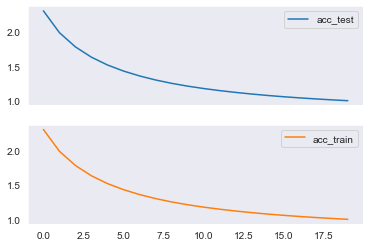

In [135]:
df1 = pd.DataFrame(epoch_acc_test, columns=['acc_test'])
df1['acc_train'] = epoch_acc_train


axes = df1.plot.line(subplots=True)

type(axes)


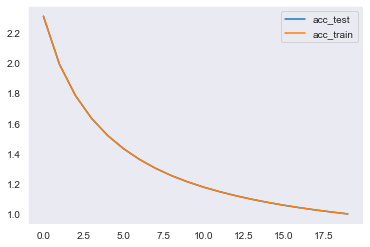

In [136]:
df1.plot.line()

In [137]:
X_test
test_df = X_test
test_df = test_df.reset_index()
test_df

title  userId  'burbs, The   (500) Days of Summer   *batteries not included   \
0       88984           0.0                    0.0                       0.0   
1      131458           0.0                    0.0                       0.0   
2      132809           0.0                    0.0                       0.0   
3       95520           2.0                    0.0                       0.0   
4       36623           0.0                    0.0                       0.0   
...       ...           ...                    ...                       ...   
27694   37271           0.0                    0.0                       0.0   
27695  123228           0.0                    0.0                       0.0   
27696   90946           0.0                    0.0                       0.0   
27697  132238           0.0                    0.0                       0.0   
27698   77571           0.0                    0.0                       0.0   

title  ...And Justice for All   10 Things I Hate About You   10,000 BC   \
0                          0.0                          0.0         0.0   
1                          0.0                          4.0         0.0   
2                          0.0                          0.0         0.0   
3                          0.0                          3.0         0.0   
4                          0.0                          0.0         0.0   
...                        ...                          ...         ...   
27694                      0.0                          0.0         0.0   
27695                      0.0                          0.0         0.0   
27696                      0.0                          0.0         0.0   
27697                      0.0                          0.0         0.0   
27698                      0.0                          0.0         0.0   

title  101 Dalmatians   101 Dalmatians (One Hundred and One Dalmatians)   \
0                  0.0                                               0.0   
1                  0.0                                               0.0   
2                  0.0                                               4.5   
3                  0.0                                               3.0   
4                  0.0                                               0.0   
...                ...                                               ...   
27694              0.0                                               0.0   
27695              0.0                                               0.0   
27696              0.0                                               0.0   
27697              0.0                                               0.0   
27698              0.0                                               0.0   

title  102 Dalmatians   ...  Zero Dark Thirty   Zero Effect   Zodiac   \
0                  0.0  ...                0.0           0.0      0.0   
1                  0.0  ...                0.0           0.0      0.0   
2                  0.0  ...                0.0           0.0      4.5   
3                  0.0  ...                0.0           0.0      0.0   
4                  0.0  ...                0.0           0.0      0.0   
...                ...  ...                ...           ...      ...   
27694              0.0  ...                0.0           0.0      0.0   
27695              0.0  ...                0.0           0.0      0.0   
27696              0.0  ...                0.0           0.0      0.0   
27697              0.0  ...                0.0           0.0      0.0   
27698              0.0  ...                0.0           0.0      0.0   

title  Zombieland   Zoolander   Zulu   [REC]   eXistenZ   xXx   \
0              0.0         0.0    0.0     0.0        0.0   0.0   
1              0.0         1.0    0.0     0.0        4.0   4.0   
2              0.0         0.0    0.0     0.0        4.5   0.0   
3              0.0         0.0    0.0     0.0        0.0   0.0   
4              0.0

In [159]:
test_df.iloc[2]

title
userId                      132809.0
'burbs, The                      0.0
(500) Days of Summer             0.0
*batteries not included          0.0
...And Justice for All           0.0
                              ...   
Zulu                             0.0
[REC]                            0.0
eXistenZ                         4.5
xXx                              0.0
¡Three Amigos!                   0.0
Name: 2, Length: 3516, dtype: float64

In [167]:
sample_user = test_df.iloc[1244][1:]

In [173]:
# pick a user
#sample_user = X_test.iloc[0,:]

#get the predicted ratings
sample_user_pred = sess.run(output_layer, feed_dict={input_layer:[sample_user]})

In [174]:
sample_user_df = pd.DataFrame(sample_user_pred, columns = moviematrix.columns)

In [175]:
sample_user_df

title  'burbs, The   (500) Days of Summer   *batteries not included   \
0          0.049055               0.164643                  0.071752   

title  ...And Justice for All   10 Things I Hate About You   10,000 BC   \
0                     0.039905                     0.272265    0.009713   

title  101 Dalmatians   101 Dalmatians (One Hundred and One Dalmatians)   \
0             0.219369                                          0.158464   

title  102 Dalmatians   12 Angry Men   ...  Zero Dark Thirty   Zero Effect   \
0             0.042207       0.412087  ...            -0.0154      0.022385   

title   Zodiac   Zombieland   Zoolander      Zulu     [REC]   eXistenZ   \
0      0.099817     0.113795    0.166781 -0.006878 -0.010531   0.129356   

title      xXx   ¡Three Amigos!   
0      0.080105         0.138933  

[1 rows x 3515 columns]

In [176]:
new_columns =sample_user_df.columns[sample_user_df.loc[sample_user_df.last_valid_index()].argsort()]
new_columns

Index(['Rio Bravo ', 'Wild at Heart ', 'Bicentennial Man ',
       'Rules of Attraction, The ', 'Random Hearts ', 'Lucas ',
       'Santa Clause 2, The ', 'Secret Life of Walter Mitty, The ',
       'Dr. Dolittle 2 ', 'Cowboy Way, The ',
       ...
       'Fugitive, The ', 'Matrix, The ', 'Braveheart ', 'Jurassic Park ',
       'Schindler's List ', 'Star Wars: Episode IV - A New Hope ',
       'Silence of the Lambs, The ', 'Forrest Gump ', 'Pulp Fiction ',
       'Shawshank Redemption, The '],
      dtype='object', name='title', length=3515)

In [177]:
sample_user_df.T.sort_values(by=0, ascending=False).head(10)

0
title                                        
Shawshank Redemption, The            2.001043
Pulp Fiction                         1.978077
Forrest Gump                         1.956343
Silence of the Lambs, The            1.900125
Star Wars: Episode IV - A New Hope   1.655127
Schindler's List                     1.606425
Jurassic Park                        1.561764
Braveheart                           1.557421
Matrix, The                          1.557031
Fugitive, The                        1.430269

In [180]:
test_df.iloc[98][1:].T.sort_values(ascending=False).head(60)

title
Shining, The                                       5.0
Inglourious Basterds                               5.0
Kill Bill: Vol. 1                                  5.0
Kill Bill: Vol. 2                                  5.0
Eternal Sunshine of the Spotless Mind              5.0
Usual Suspects, The                                5.0
Manhattan                                          5.0
Days of Heaven                                     5.0
Insomnia                                           5.0
Spider-Man 2                                       5.0
Insider, The                                       5.0
Indiana Jones and the Last Crusade                 5.0
Goodfellas                                         5.0
Lost in La Mancha                                  5.0
Good Will Hunting                                  5.0
Inception                                          5.0
Clockwork Orange, A                                5.0
Sting, The                                         5.0
Grou

In [119]:
sample_user_df = pd.DataFrame(sample_user_pred, columns = moviematrix.columns)
new_columns =sample_user_df.columns[sample_user_df.loc[sample_user_df.last_valid_index()].argsort()]
sample_user_df[new_columns[-10:]].T.sort_values(by=0, ascending=False).head(10)

0
title                                         
Quiet American, The                  11.966257
Die Hard                             11.725642
Shanghai Knights                     10.655059
Score, The                           10.381365
Stop! Or My Mom Will Shoot           10.279697
Escape from the Planet of the Apes   10.078184
Return of the Living Dead, The       10.038986
Twister                               9.912963
Hot Shots!                            9.831491
Home Fries                            9.713680

In [57]:
# picking a user and seeing what movies are recommended to him
sample_user = X_test.iloc[0]

# get the predicted ratings
sample_user_pred = sess.run(output_layer, feed_dict={input_layer:[sample_user]})
sample_user_df = pd.DataFrame(sample_user_pred, columns = moviematrix.columns)
new_columns =sample_user_df.columns[sample_user_df.loc[sample_user_df.last_valid_index()].argsort()]
sample_user_df[new_columns[-10:]].T.sort_values(by=0, ascending=False).head(10)

0
title                               
Silence of the Lambs, The   1.614378
Forrest Gump                1.595183
Sixth Sense, The            1.510425
Matrix, The                 1.436083
Mary Poppins                1.413907
Bourne Supremacy, The       1.356782
Jewel of the Nile, The      1.350697
Toy Story                   1.347667
Schindler's List            1.326557
Secret of Roan Inish, The   1.309558

In [62]:
test_df = X_test
test_df = test_df.reset_index()
test_df[test_df['userId']==105300.0].T[2:].sort_values(by=99, ascending=False).head(4)

99
title                                   
American President, The              5.0
Twelve Monkeys (a.k.a. 12 Monkeys)   5.0
Shawshank Redemption, The            5.0
Philadelphia                         5.0

# Limitations

- abc